In [140]:
# Group number 1
# Project 5
# Team members: Stepan Perminov, Polina Ponomareva, Kirill Shcherbakov, Daniil Svirskiy

# Library importing
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [141]:
# Kalman filter algorithm
class Filtration(object):
    def __init__(self, T, sx2, sy2, sa2):

        # Initial conditions for Kalman filter algorithm
        self.X0 = np.array([0, 0, 0, 0])
        self.P0 = np.eye(4)*(10**5)
        
        # Matrixes for filtering
        self.F = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
        self.G = np.array([[T*T/2, 0], [T, 0], [0, T*T/2], [0, T]])
        self.Q = (self.G).dot((self.G).T)*sa2
        self.H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
        
        # Covariance matrix of measurement errors R
        self.R = np.array([[sx2, 0], [0, sy2]])
                     
    def Kalman_filtration(self, n, Zc, param):
        P0 = self.P0
        X0 = self.X0
        F = self.F
        R = self.R
        Q = self.Q
        H = self.H
        
        # Initialization of matrices
        P_1 = np.zeros((4,4,n))
        X_1 = np.zeros((4,n))
        P_ = np.zeros((4,4,n))
        X_ = np.zeros((4,n))
        residual = np.zeros((2,n))
        K00 = np.zeros(n)

        # Initial filtration error covariance matrix P0 for filtering
        P_[:,:,0] = P0

        # Initial state vector X0 for filtering
        X_[:,0] = X0

        # Kalman filtering
        for i in range(1,n):
            P_1[:,:,i] = (F.dot(P_[:,:,i-1])).dot(F.T) + Q

            X_1[:,i] = F.dot(X_[:,i-1].reshape(4,1)).reshape(4)
                         
            K = (P_1[:,:,i].dot(H.T)).dot(inv((H.dot(P_1[:,:,i])).dot(H.T) + R)) #4 on 2
            K00[i] = K[0, 0]
        
            X_[:,i] = (X_1[:,i].reshape(4,1) + K.dot(Zc[:,i].reshape(2,1) - H.dot(X_1[:,i].reshape(4,1)))).reshape(4)
                        
            residual[:,i] = abs(Zc[:,i] - H.dot(X_1[:,i]))
            
            if (residual[0,i] > param*np.sqrt(sigma_x2)) and (residual[1,i] > param*np.sqrt(sigma_y2)):
                P_[:,:,i] = P_[:,:,0]
            else:
                P_[:,:,i] = P_1[:,:,i] - (K.dot(H)).dot(P_1[:,:,i])
             # P_[:,:,i] = P_1[:,:,i] - (K.dot(H)).dot(P_1[:,:,i])

        residual = np.delete(residual, 0, axis = 1)
        K00 = np.delete(K00, 0, axis = 0)
        # print(residual.shape)
        X_estimate = np.zeros((2,n))
        V_estimate = np.zeros((2,n))
        X_estimate[0,:] = X_[0,:]
        X_estimate[1,:] = X_[2,:]
        V_estimate[0,:] = X_[1,:]
        V_estimate[1,:] = X_[3,:]
        
        # Backward smoothing
        X_new = np.zeros((4,n))
        X_new[:,-1] = X_[:,-1]
        P_new = np.zeros((4,4,n))
        P_new[:,:,-1] = P_[:,:,-1]
    
        for i in reversed(range(n-1)):
            Ai = P_[:,:,i].dot(F.T).dot(inv(P_1[:,:,i+1]))
            X_new[:,i] = X_[:,i] + Ai.dot(X_new[:,i+1] - F.dot(X_[:,i]))
            P_new[:,:,i] = P_[:,:,i] + Ai.dot(P_new[:,:,i+1] - P_1[:,:,i+1]).dot(Ai.T)
        
        X_estimate_new = np.zeros((2,n))
        V_estimate_new = np.zeros((2,n))
        X_estimate_new[0,:] = X_new[0,:]
        X_estimate_new[1,:] = X_new[2,:]
        V_estimate_new[0,:] = X_new[1,:]
        V_estimate_new[1,:] = X_new[3,:]
        
        return X_estimate, V_estimate, residual, K00, X_estimate_new, V_estimate_new
    
    def running_mean(self, M, measurements, numbers_points, true_traj):
        # creating of the smooth array for measurements
        x_smooth = np.zeros((numbers_points, 1))
        # auxiliary number which is used in the formula for calculating
        anum = (M - 1) / 2.0
        # because of anum is float and for for-loop we need int type of number, we change the type of variable
        anum = int(anum)
        # print(anum)
    
        # in order to calculate the average values for first and last elements
        # which cannot be calculated be running mean method
        # we calculate sums of first from 0 to anum (not included) elements
        # and last from numbers_points - anum to numbers_points(not included) elements
        sum_first_elements = np.sum(true_traj[0: anum, :])
        sum_last_elements = np.sum(true_traj[numbers_points - anum: numbers_points, :])
    
        # calculate the average values for first and last elements as sum of elements divided by their quantity
        x_smooth[0: anum, :] = sum_first_elements / anum
        x_smooth[numbers_points - anum: numbers_points, :] = sum_last_elements / anum
    
        # calculating the values with running mean method
        for i in range(anum, numbers_points - anum):
            # coefficient from the dividing

            # print(x_smooth[i])
            # sum of array with M elements
            x_smooth[i] = np.sum(measurements[i - anum: i + anum, :]) / float(M)
            
        # print(x_smooth.shape)
        return x_smooth
    
    
    def running_mean_Stepa(self, M, z, n):
        # Running mean application
        run_mean = np.zeros((n,1))
        
        M_half = M/2
        print(M_half)
        
        # First 3 and last 3 measurements are replaced by corresponding average values
        beg_mean = np.sum(z[:M_half])/len(z[:M_half])
        end_mean = np.sum(z[len(z)-M_half:])/len(z[len(z)-M_half:])
        
        # Running mean calculation
        for i in range(len(z)):
            if i <= M_half-1:
                run_mean[i] = beg_mean
            elif i >= len(z)-M_half:
                run_mean[i] = end_mean
            else:
                run_mean[i] = np.sum(z[i-M_half:i+M_half+1])/len(z[i-M_half:i+M_half+1])
        return run_mean
    
    def exp_forward_smoothing(self, alfa, z, n):
        sm = np.zeros((n,1))
        sm[0] = z[0]
        
        for i in range(1,len(z)):
            sm[i] = sm[i-1] + alfa*(z[i] - sm[i-1])
        
        return sm
    
    def exp_backward_smoothing(self, alfa, sm, n):
        sm_b = np.zeros((n,1))
        sm_b[-1] = sm[-1]
        
        for i in reversed(range(len(sm)-1)):
            sm_b[i] = sm_b[i+1] + alfa*(sm[i] - sm_b[i+1])
            
        return sm_b

In [142]:
# Parameters / Inputs

# Measurements
measurements = np.loadtxt(fname = "z.txt")
measurements = measurements.T

# Points
N = len(measurements[0,:]) 

T = 1 #interval between measurements (Input!!)

# Variances
# For an acceleration
sigma_a2 = 0.01**2
# For x
sigma_x2 = 10**2
# For y
sigma_y2 = sigma_x2

param = 2.4

M = 21
alfa = 0.07

10
10


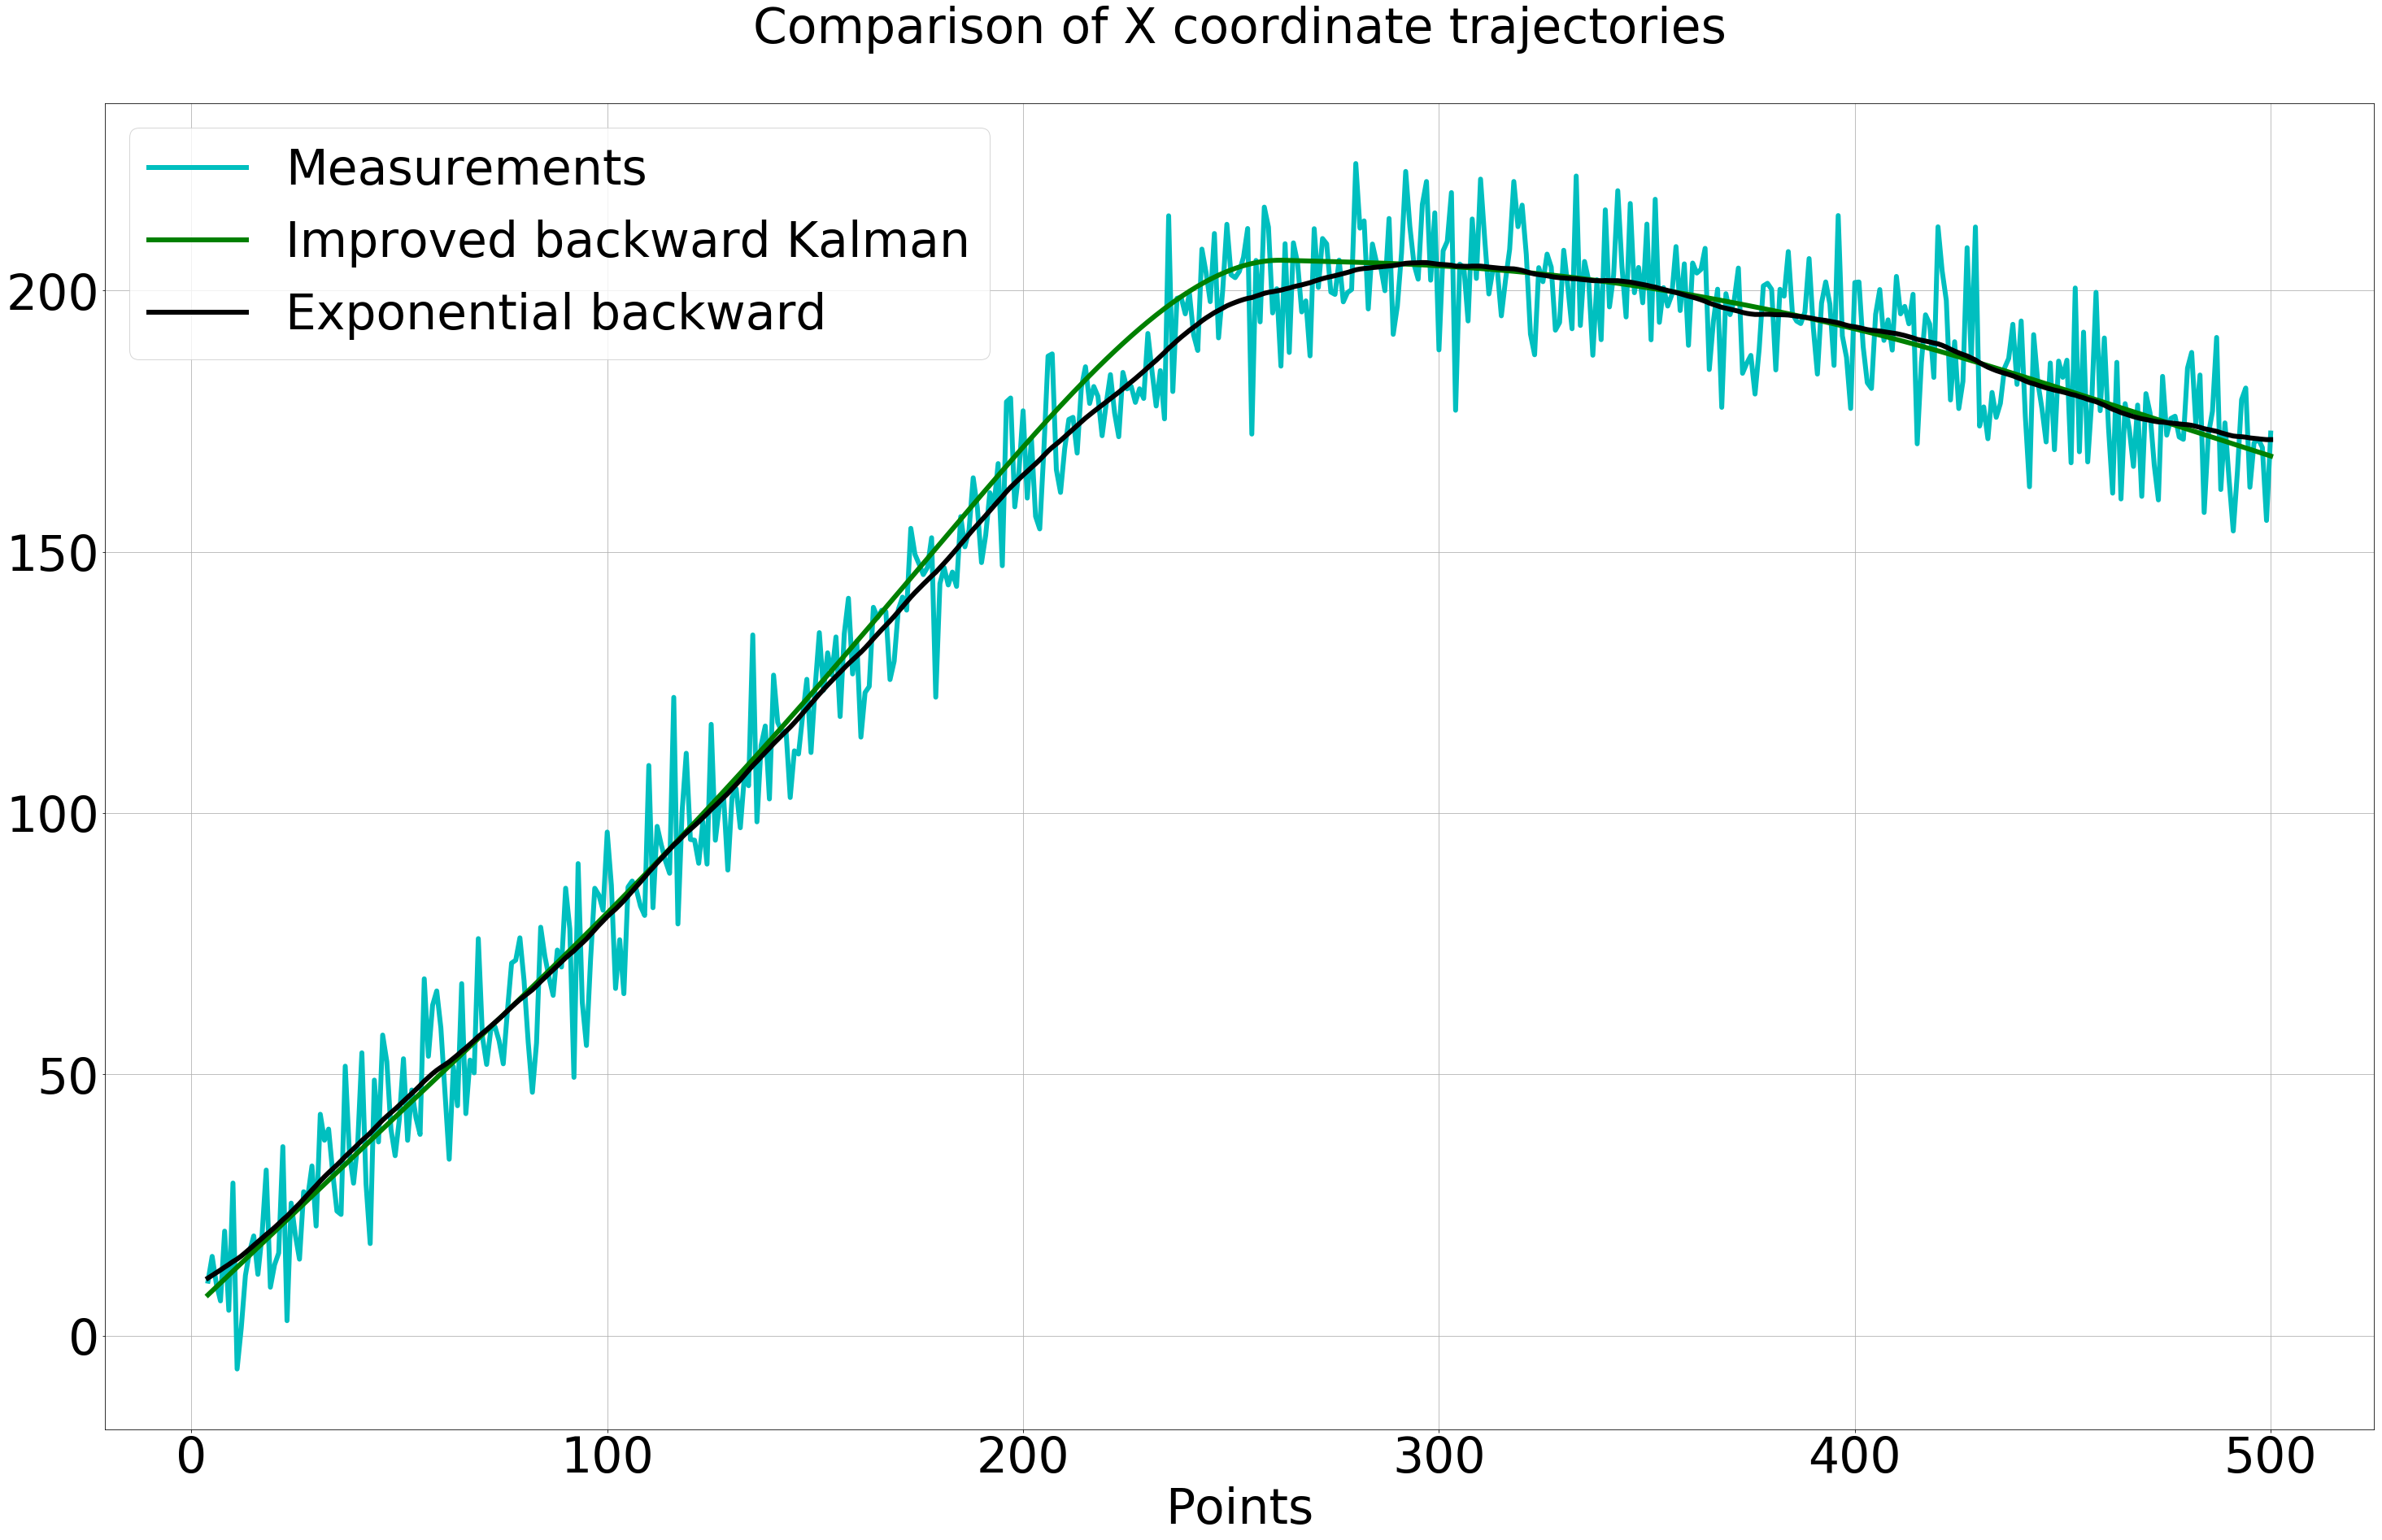

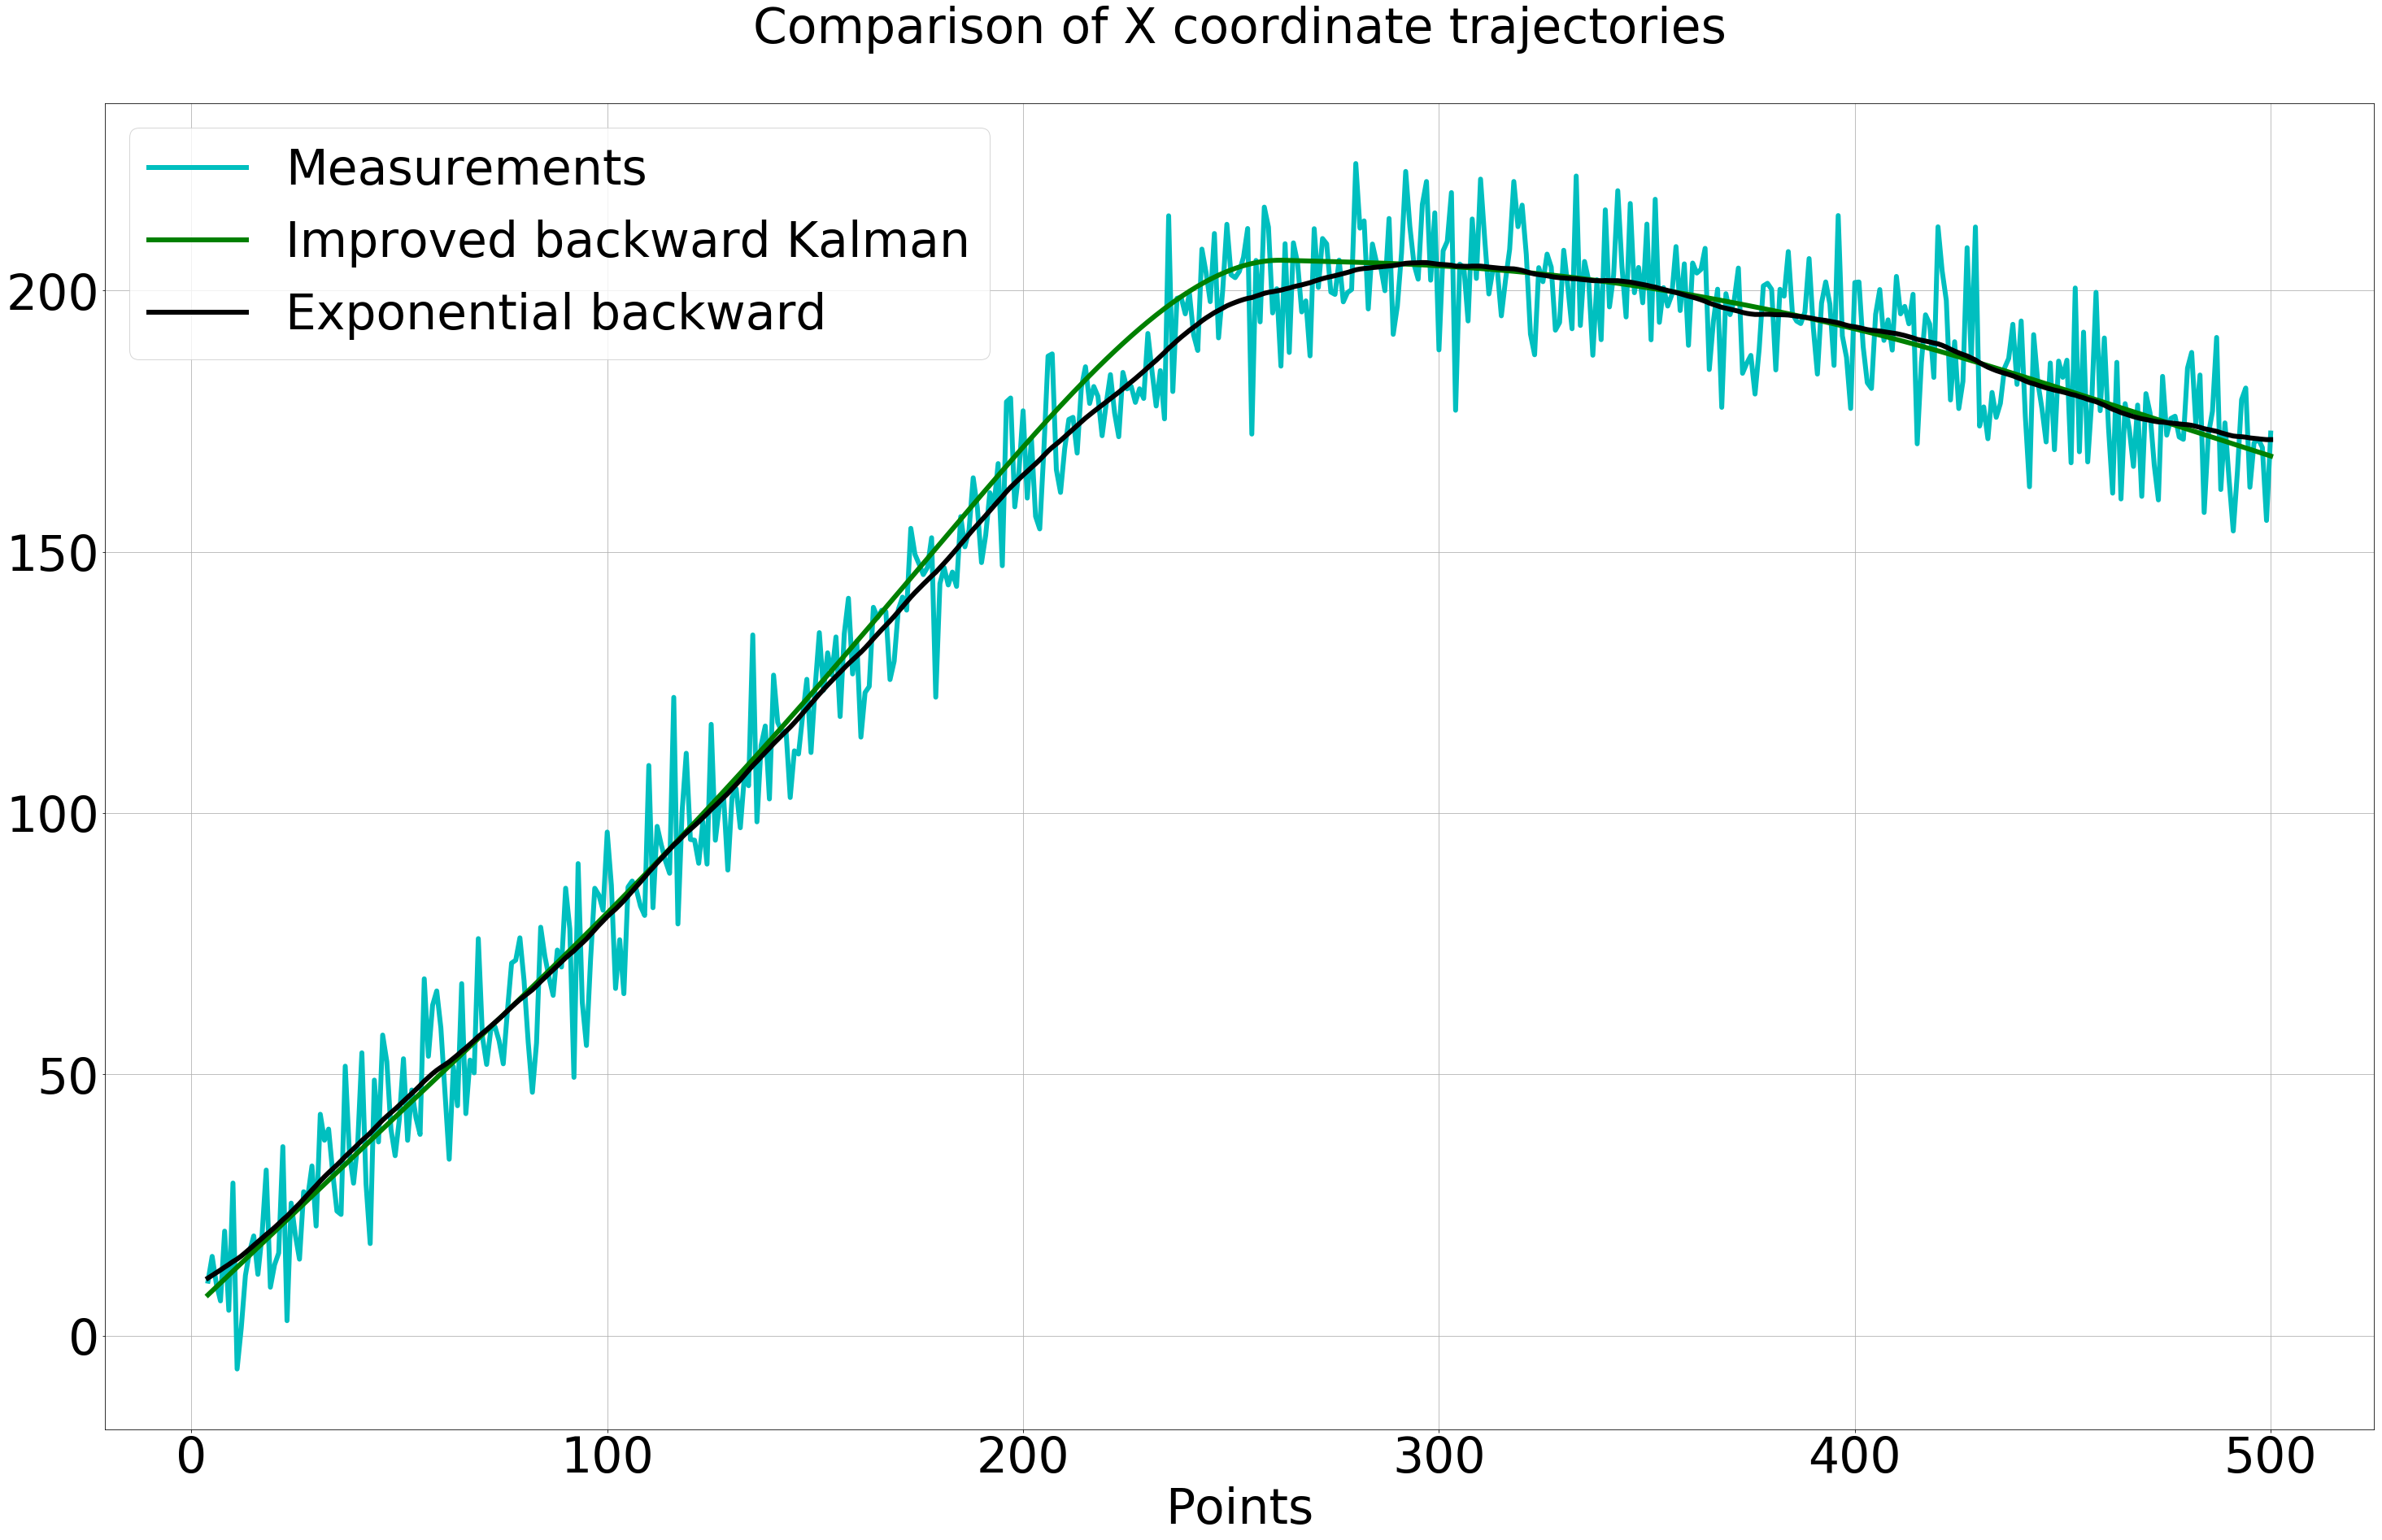

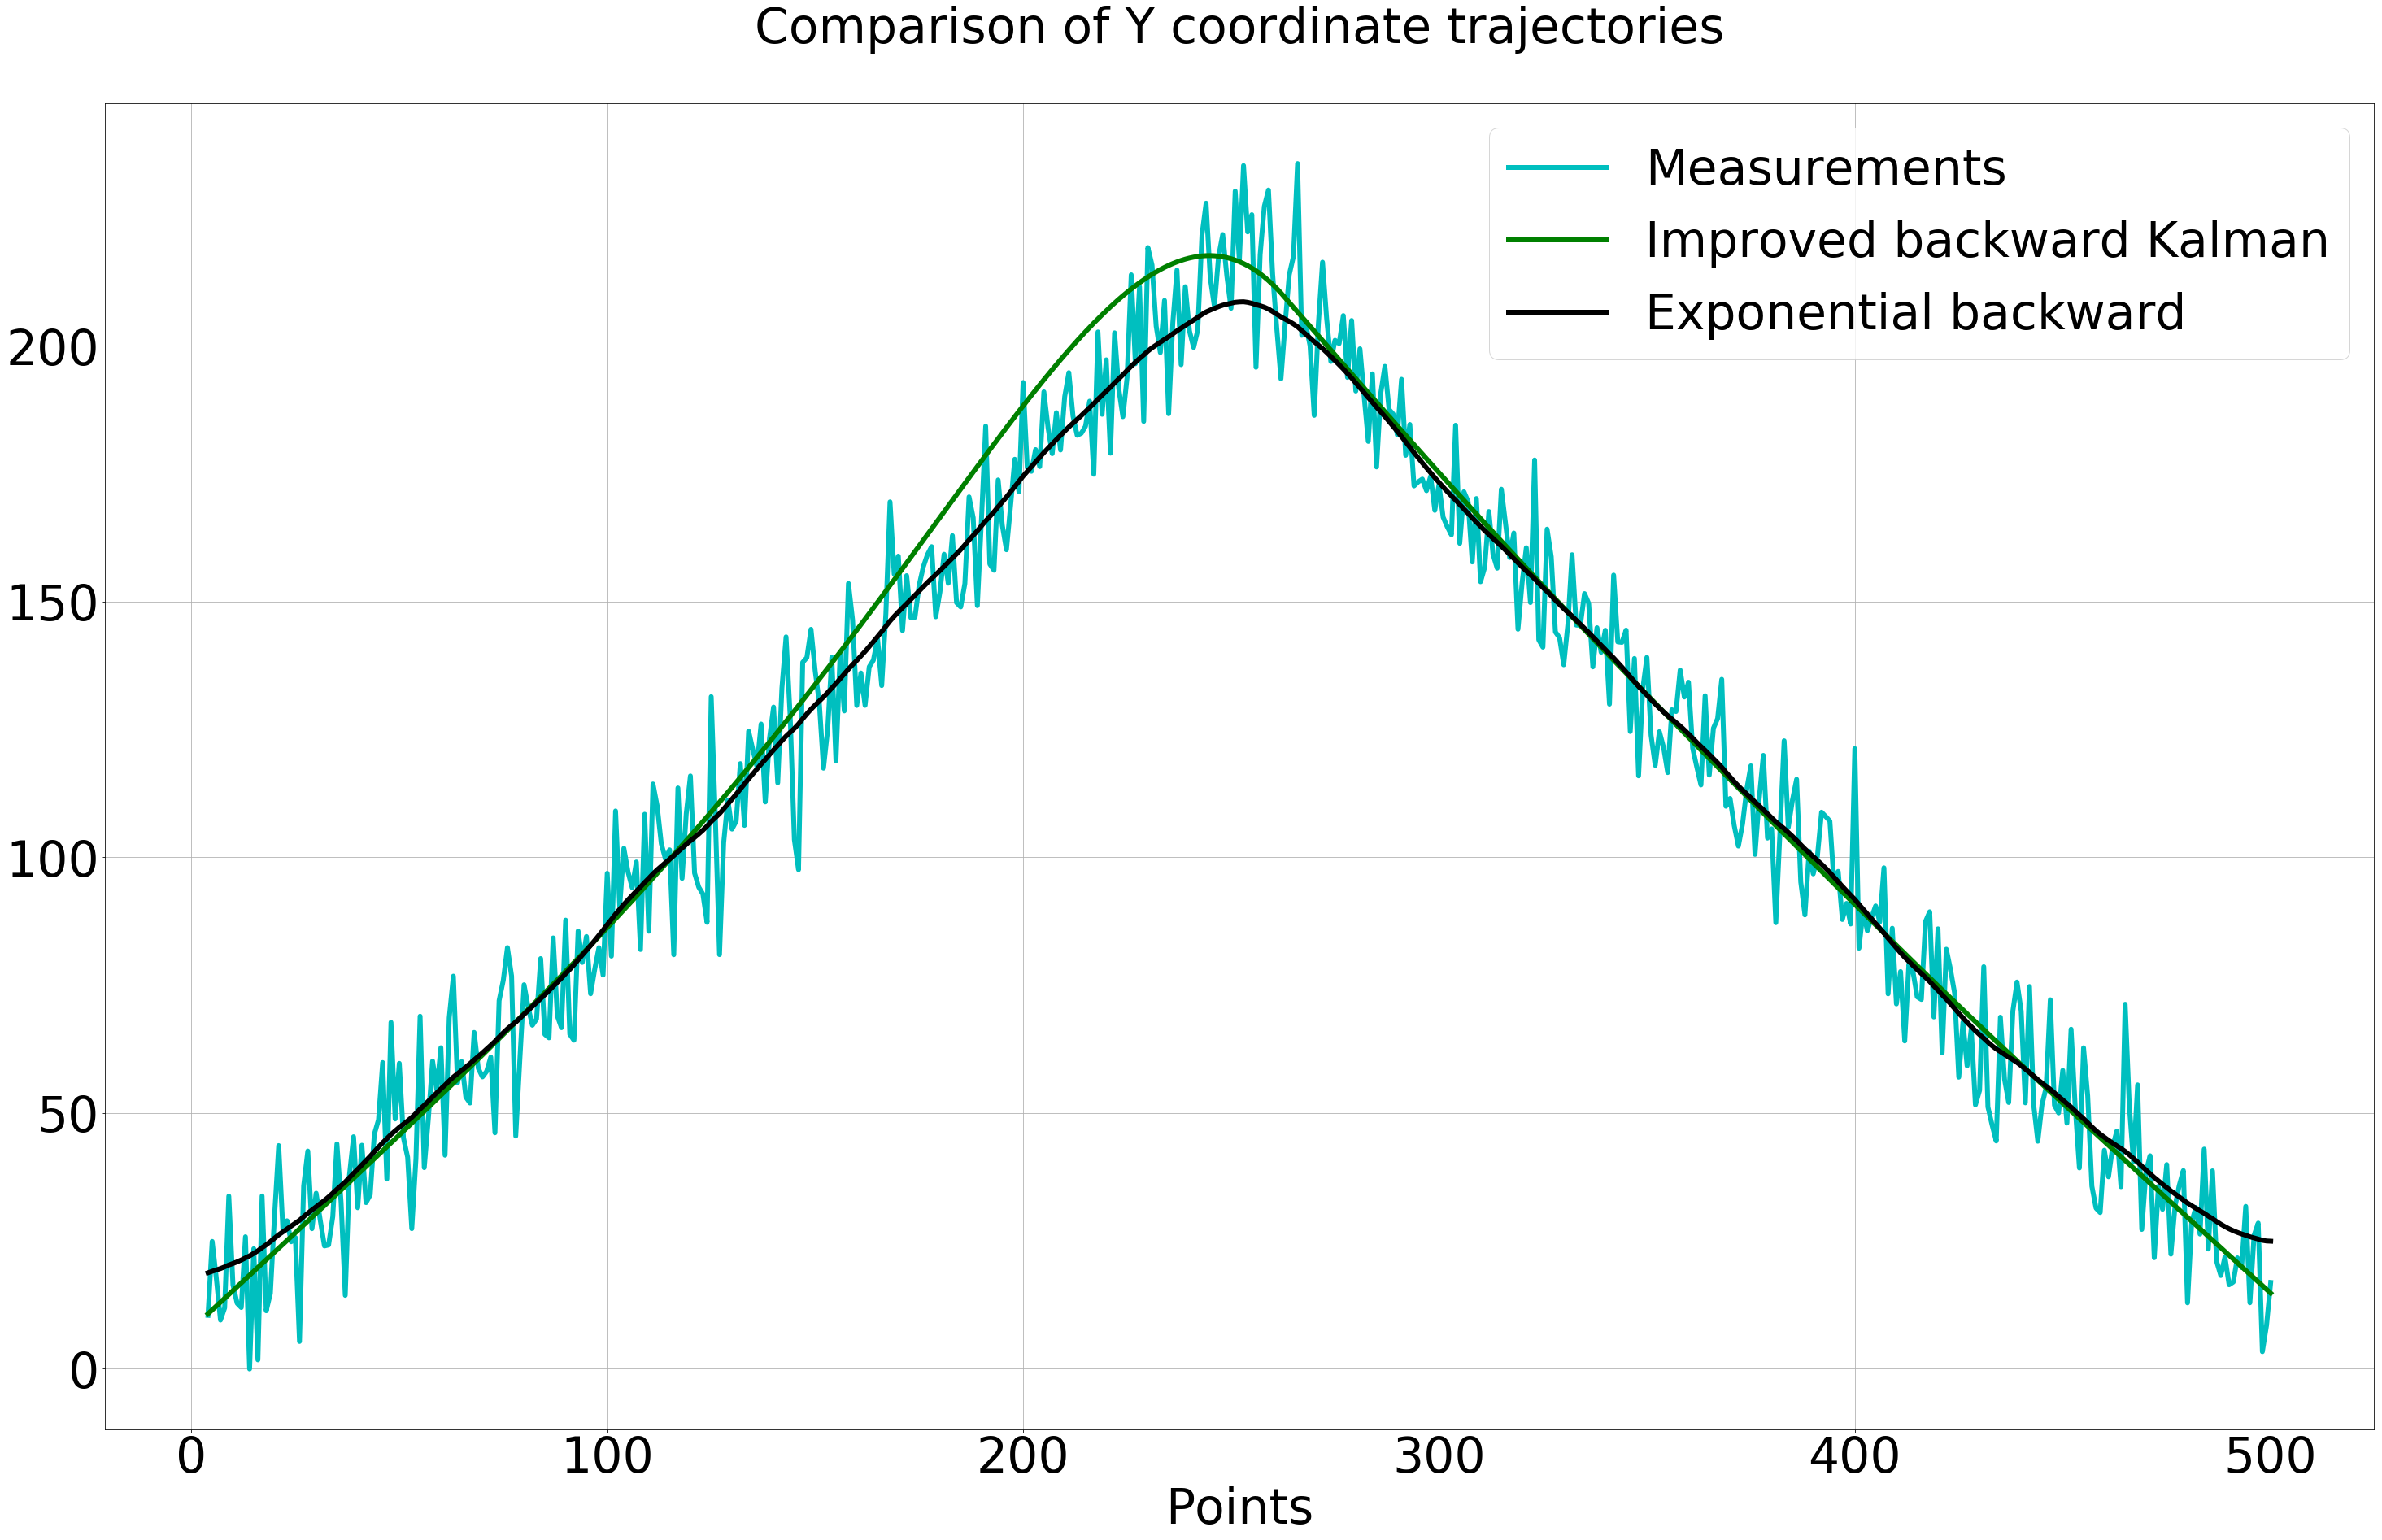

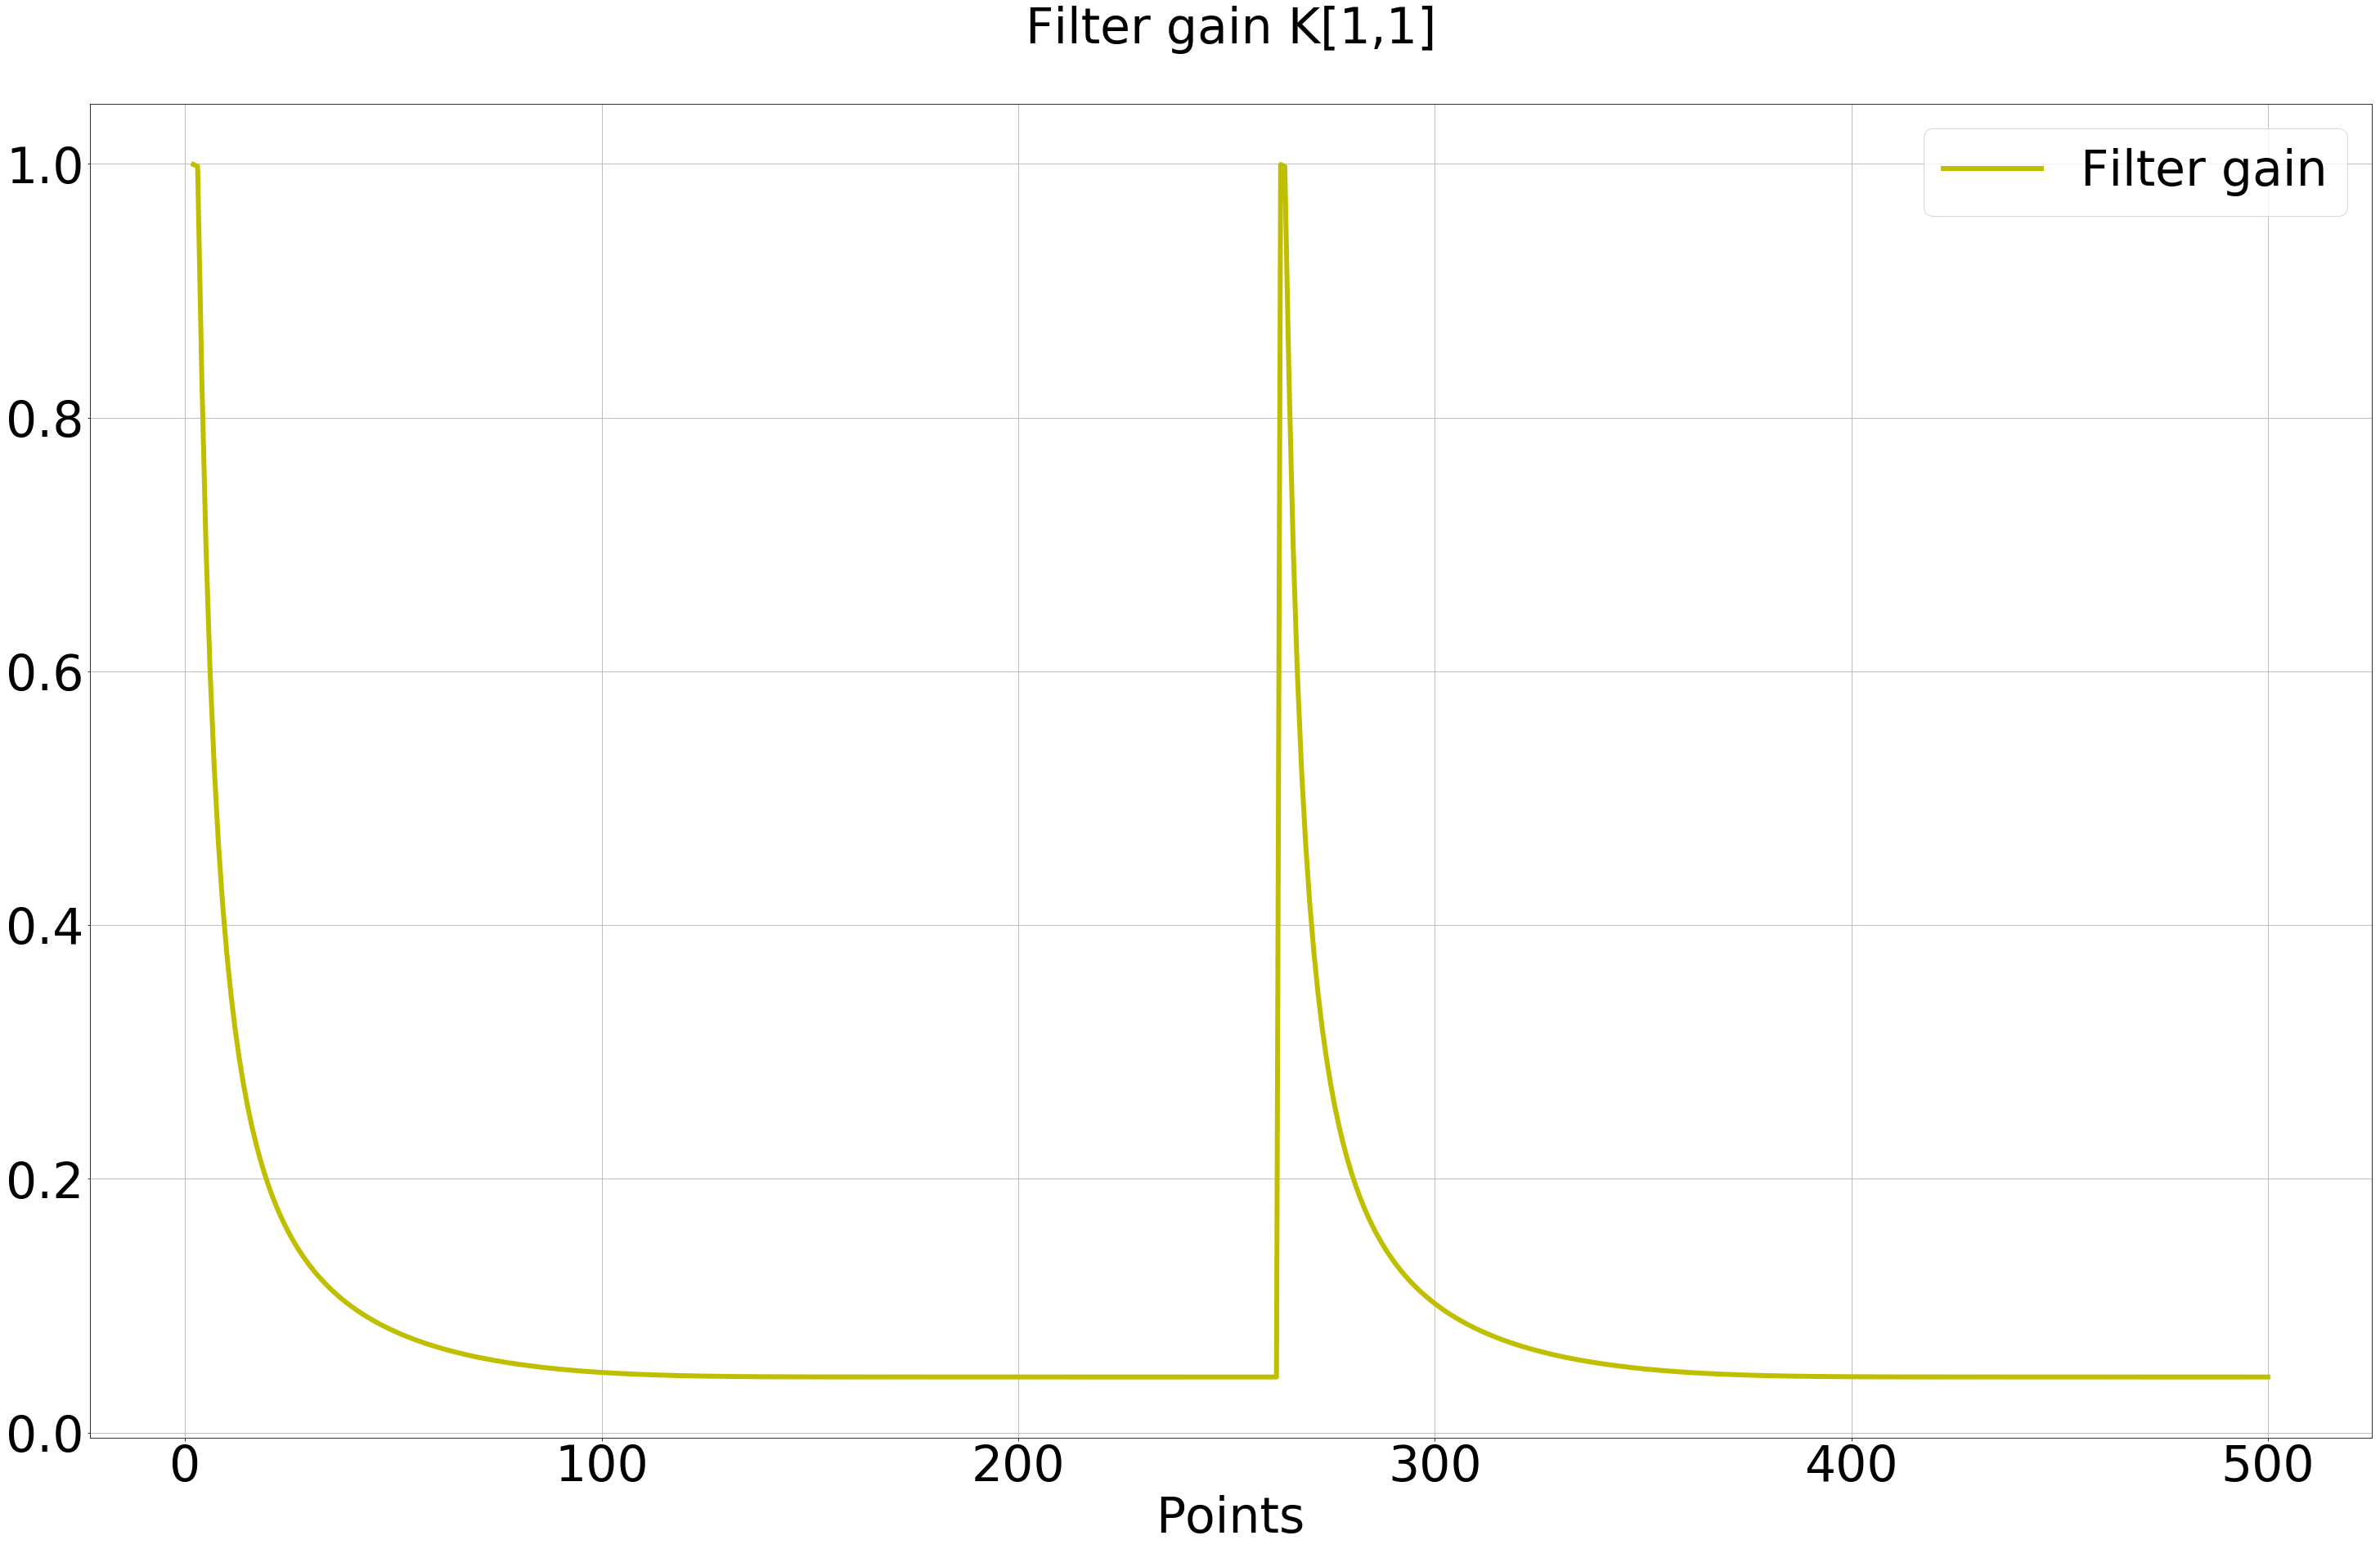

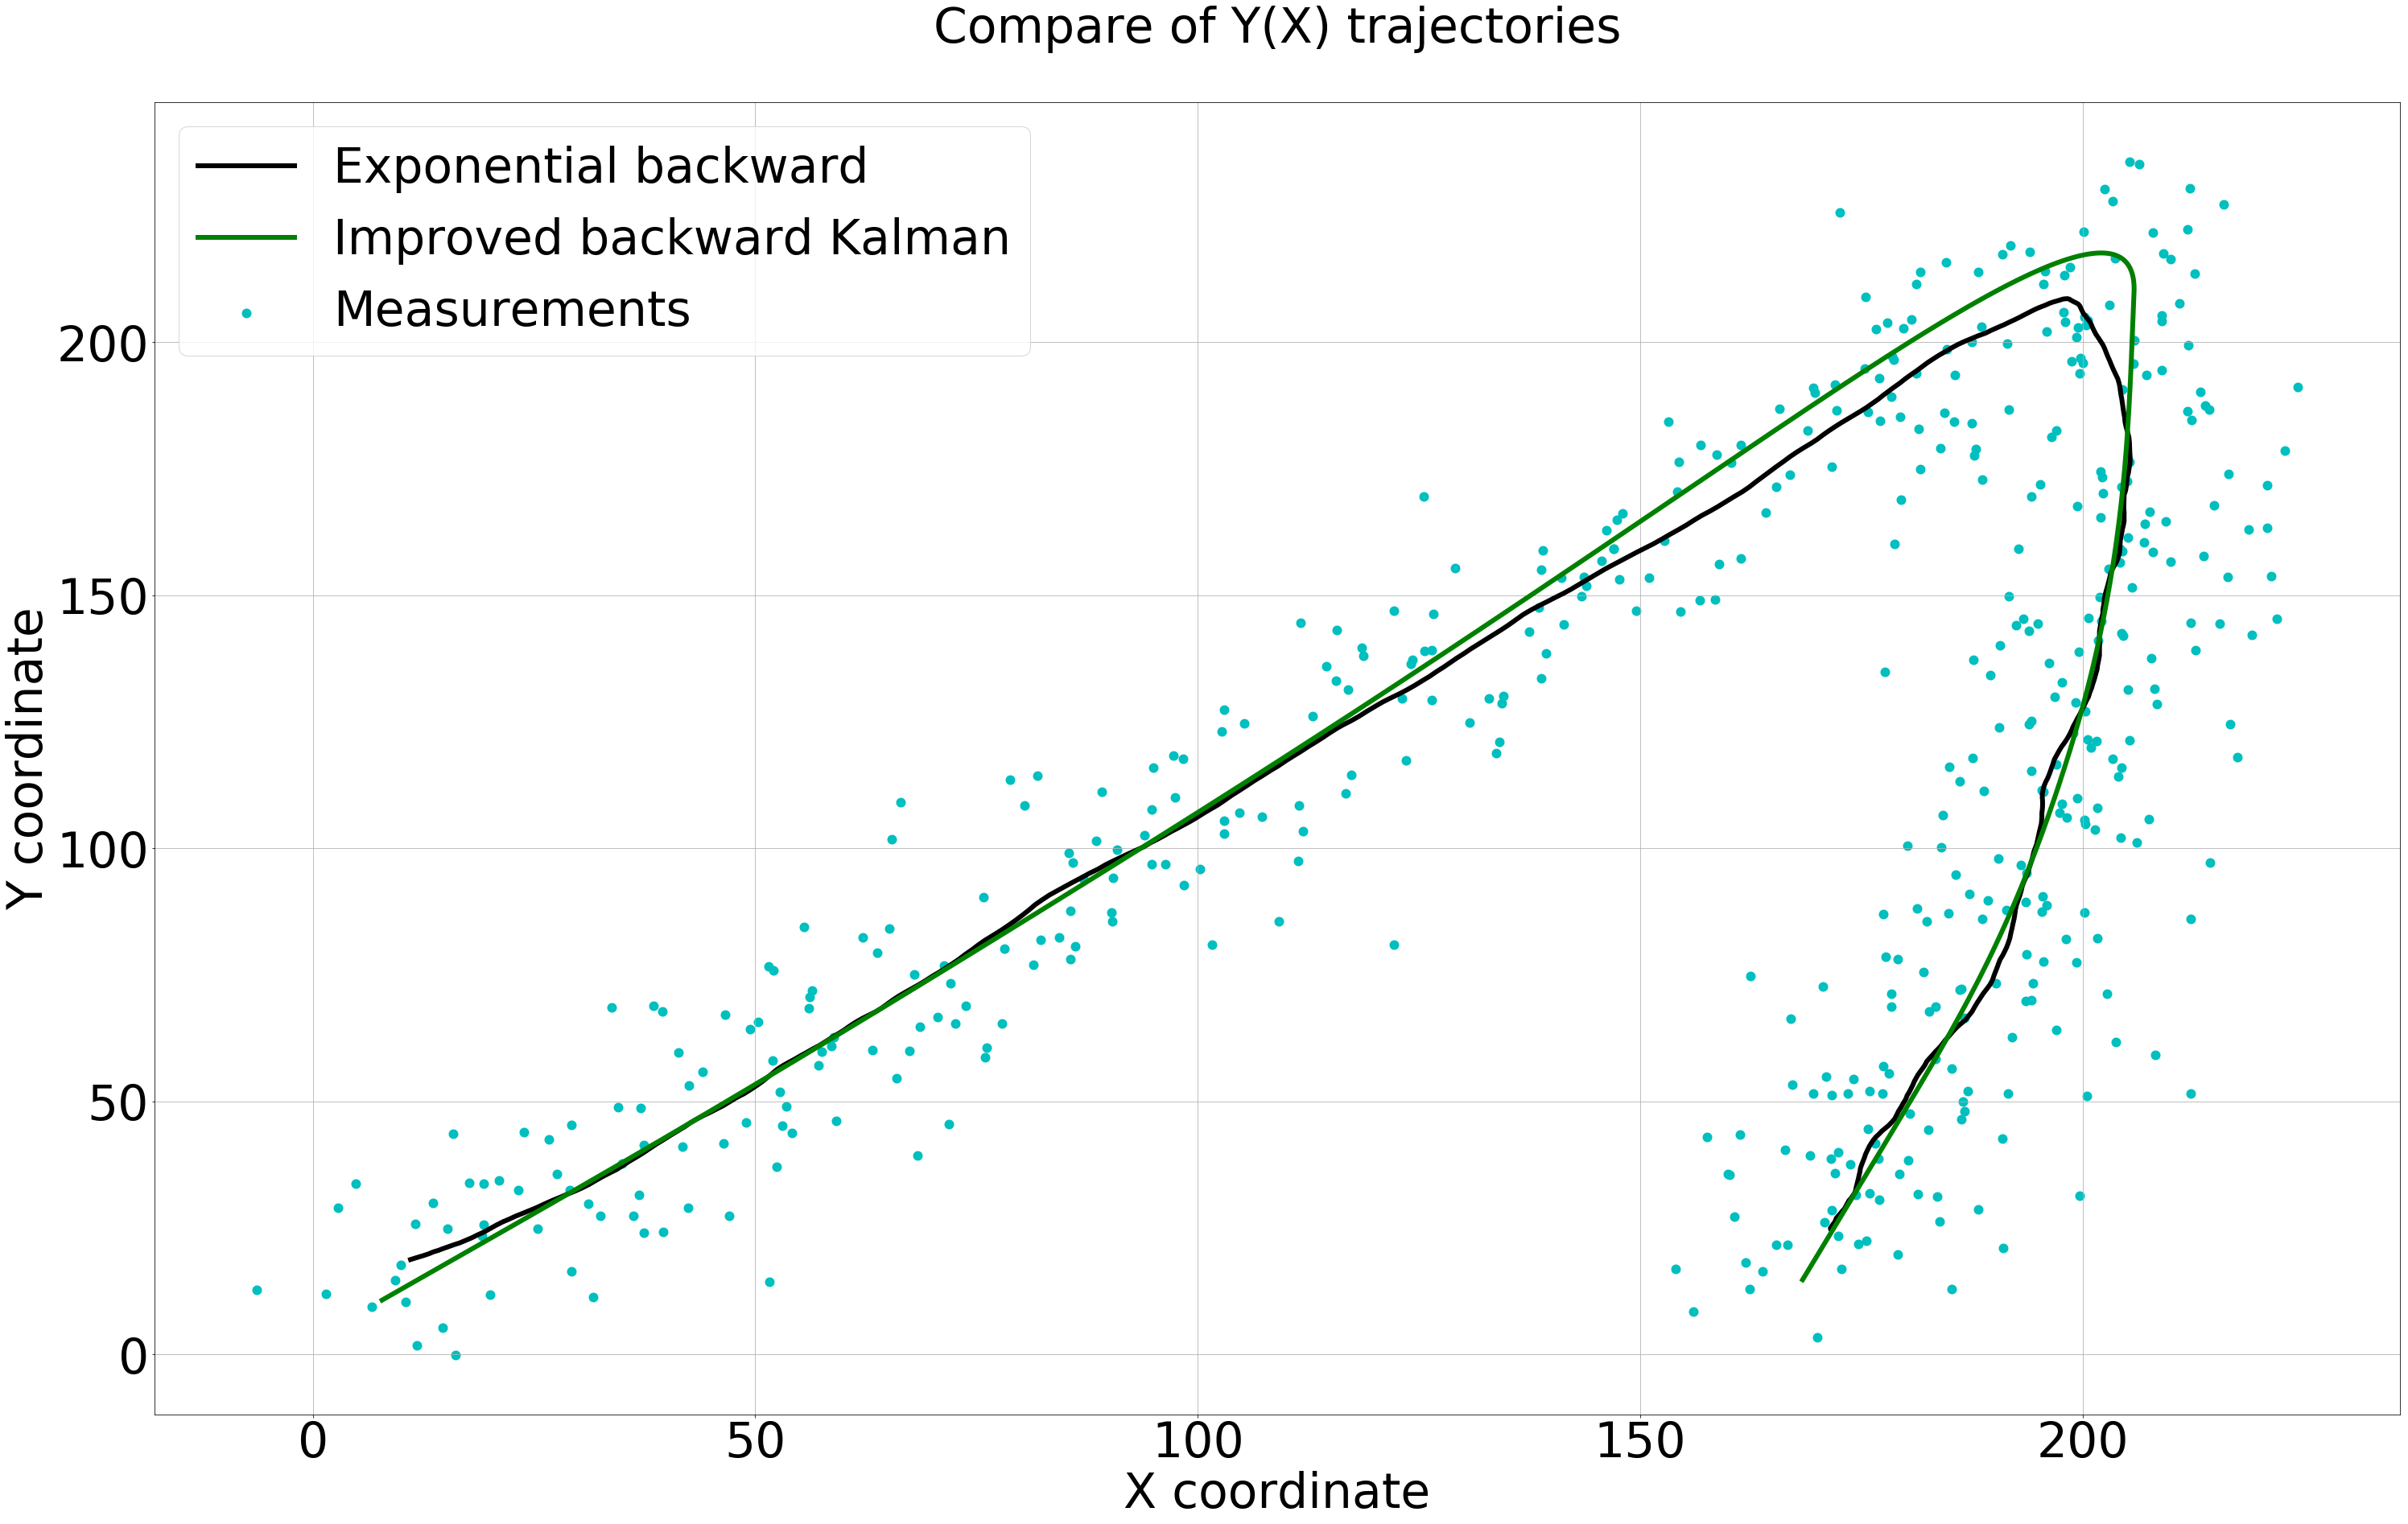

In [145]:
if __name__ == "__main__":
   
    # Extrapolated and filtered estimates
    X_filt, V_filt, residual, K_gain, X_smoothed, V_smoothed = Filtration(T, sigma_x2, sigma_y2, sigma_a2).Kalman_filtration(N, measurements, param)
    
    X_mean = np.zeros((2,N))
    X_mean[0,:] = (Filtration(T, sigma_x2, sigma_y2, sigma_a2).running_mean_Stepa(M, measurements[0,:].reshape(N,1), N)).reshape(N)
    X_mean[1,:] = (Filtration(T, sigma_x2, sigma_y2, sigma_a2).running_mean_Stepa(M, measurements[1,:].reshape(N,1), N)).reshape(N)

    X_exp_forward = np.zeros((2,N))
    X_exp_forward[0,:] = (Filtration(T, sigma_x2, sigma_y2, sigma_a2).exp_forward_smoothing(alfa, measurements[0,:].reshape(N,1), N)).reshape(N)
    X_exp_forward[1,:] = (Filtration(T, sigma_x2, sigma_y2, sigma_a2).exp_forward_smoothing(alfa, measurements[1,:].reshape(N,1), N)).reshape(N)

    X_exp_backward = np.zeros((2,N))
    X_exp_backward[0,:] = (Filtration(T, sigma_x2, sigma_y2, sigma_a2).exp_backward_smoothing(alfa, X_exp_forward[0,:].reshape(N,1), N)).reshape(N)
    X_exp_backward[1,:] = (Filtration(T, sigma_x2, sigma_y2, sigma_a2).exp_backward_smoothing(alfa, X_exp_forward[1,:].reshape(N,1), N)).reshape(N)


    points = range(1,N+1)
    # Plot of measurements
    plt.plot(points[3:], measurements[0,3:], linewidth = 6, label = "Measurements", color = "c")
    # Plot of filtered estimates
    # plt.plot(points[3:], X_filt[0,3:], linewidth = 6, label = "Kalman filtered estimates", color = "b")
    plt.plot(points[3:], X_smoothed[0,3:], linewidth = 6, label = "Improved backward Kalman", color = "g")
    # plt.plot(points[3:], X_mean[0,3:], linewidth = 6, label = "Mean filtered", color = "k")
    # plt.plot(points[3:], X_exp_forward[0,3:], linewidth = 6, label = "Exp forward filtered", color = "m")
    plt.plot(points[3:], X_exp_backward[0,3:], linewidth = 6, label = "Exponential backward", color = "k")
    
    
    plt.legend(fontsize = 60)
    plt.rcParams["figure.figsize"] = (50,30)
    plt.grid()
    plt.tick_params(labelsize = 60)
    plt.xlabel("Points", fontsize = 60)
    plt.title("Comparison of X coordinate trajectories\n", fontsize = 60)
    plt.show()
    
    # Plot of measurements
    plt.plot(points[3:], measurements[0,3:], linewidth = 6, label = "Measurements", color = "c")
    # Plot of filtered estimates
    # plt.plot(points[3:], X_filt[0,3:], linewidth = 6, label = "Kalman filtered estimates", color = "b")
    plt.plot(points[3:], X_smoothed[0,3:], linewidth = 6, label = "Improved backward Kalman", color = "g")
    # plt.plot(points[3:], X_mean[0,3:], linewidth = 6, label = "Mean filtered", color = "k")
    # plt.plot(points[3:], X_exp_forward[0,3:], linewidth = 6, label = "Exp forward filtered", color = "m")
    plt.plot(points[3:], X_exp_backward[0,3:], linewidth = 6, label = "Exponential backward", color = "k")
    
    
    plt.legend(fontsize = 60)
    plt.rcParams["figure.figsize"] = (50,30)
    plt.grid()
    plt.tick_params(labelsize = 60)
    plt.xlabel("Points", fontsize = 60)
    plt.title("Comparison of X coordinate trajectories\n", fontsize = 60)
    plt.show()

    # #   Plot of residual
    # plt.plot(points[1:], residual[0,:], linewidth = 6, label = "Residual of X", color = "y")
    # plt.legend(fontsize = 60)
    # plt.rcParams["figure.figsize"] = (50,30)
    # plt.grid()
    # plt.tick_params(labelsize = 60)
    # plt.xlabel("Points", fontsize = 60)
    # plt.title("Residual for X coordinate\n", fontsize = 60)
    # plt.show()

    #   Plot of measurements
    plt.plot(points[3:], measurements[1,3:], linewidth = 6, label = "Measurements", color = "c")
    # Plot of filtered estimates
    # plt.plot(points[3:], X_filt[1,3:], linewidth = 6, label = "Kalman filtered estimates", color = "b")
    plt.plot(points[3:], X_smoothed[1,3:], linewidth = 6, label = "Improved backward Kalman", color = "g")
    # plt.plot(points[3:], X_mean[1,3:], linewidth = 6, label = "Mean filtered", color = "k")
    # plt.plot(points[3:], X_exp_forward[1,3:], linewidth = 6, label = "Exp forward filtered", color = "m")
    plt.plot(points[3:], X_exp_backward[1,3:], linewidth = 6, label = "Exponential backward", color = "k")
    
    plt.legend(fontsize = 60)
    plt.rcParams["figure.figsize"] = (50,30)
    
    plt.grid()
    plt.tick_params(labelsize = 60)
    plt.xlabel("Points", fontsize = 60)
    plt.title("Comparison of Y coordinate trajectories\n", fontsize = 60)
    plt.show()

    # #   Plot of residual
    # plt.plot(points[1:], residual[1,:], linewidth = 6, label = "Residual of Y", color = "y")
    # plt.legend(fontsize = 60)
    # plt.rcParams["figure.figsize"] = (50,30)
    # plt.grid()
    # plt.tick_params(labelsize = 60)
    # plt.xlabel("Points", fontsize = 60)
    # plt.title("Residual for Y coordinate\n", fontsize = 60)
    # plt.show()

    # Plot of K gain
    plt.plot(points[1:], K_gain, linewidth = 6, label = "Filter gain", color = "y")
    plt.legend(fontsize = 60)
    plt.rcParams["figure.figsize"] = (50,30)
    plt.grid()
    plt.tick_params(labelsize = 60)
    plt.xlabel("Points", fontsize = 60)
    plt.title("Filter gain K[1,1]\n", fontsize = 60)
    plt.show()
    
    
    plt.scatter(measurements[0,3:], measurements[1,3:], linewidth = 6, label = "Measurements", color = "c")
    plt.plot(X_exp_backward[0,3:], X_exp_backward[1,3:], linewidth = 6, label = "Exponential backward", color = "k")
    plt.plot(X_smoothed[0,3:], X_smoothed[1,3:], linewidth = 6, label = "Improved backward Kalman", color = "g")
    # plt.plot(X_filt[0,3:], X_filt[1,3:], linewidth = 6, label = "Kalman filtered estimates", color = "b")
    
    
    plt.legend(fontsize = 60)
    plt.rcParams["figure.figsize"] = (50,30)
    plt.grid()
    plt.tick_params(labelsize = 60)
    plt.xlabel("X coordinate", fontsize = 60)
    plt.ylabel("Y coordinate", fontsize = 60)
    plt.title("Compare of Y(X) trajectories\n", fontsize = 60)
    plt.show()
    
    
    residual_Kalman_smoothed = abs(measurements - X_smoothed)
    residual_exp_backward = abs(measurements - X_exp_backward)
    
    plt.plot(points[3:], residual_Kalman_smoothed[0,3:], linewidth = 6, label = "Deviation of Kalman smoothed X", color = "y")
    plt.plot(points[3:], residual_Kalman_smoothed[1,3:], linewidth = 6, label = "Deviation of Kalman smoothed Y", color = "r")
    plt.plot(points[3:], residual_exp_backward[0,3:], linewidth = 6, label = "Deviation of Exp smoothed backward X", color = "c")
    plt.plot(points[3:], residual_exp_backward[1,3:], linewidth = 6, label = "Deviation of Exp smoothed backward Y", color = "b")
    
    plt.legend(fontsize = 60)
    plt.rcParams["figure.figsize"] = (16,9)
    plt.grid()
    plt.tick_params(labelsize = 60)
    plt.xlabel("Points", fontsize = 60)
    plt.title("Compare of deviations\n", fontsize = 60)
    plt.show()
    
    

(499,)